In [28]:


%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
from math import sqrt
import scipy as sp

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survLime.datasets.load_datasets import Loader 
from survLime import survlime_tabular


dataset = 'pbc'
loader = Loader(dataset_name=dataset)
x,events, times = loader.load_data()



train, val, test = loader.preprocess_datasets(x, events, times, random_seed=50, standarize=True)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_val = [x[0] for x in val[1]]
times_val  = [x[1] for x in val[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]



model = CoxPHSurvivalAnalysis(alpha=0.0001)
#model = RandomSurvivalForest()
model.fit(train[0], train[1])

def compare_survival_times(bb_model : CoxPHSurvivalAnalysis,
                           coefs : np.ndarray,
                           X_train : pd.DataFrame, y_train : np.ndarray, X_test : pd.DataFrame, true_coef : list = None):

    times_train = [x[1] for x in y_train]
    times_to_fill = list(set(times_train)); times_to_fill.sort()
    
    model_interpretable = CoxPHSurvivalAnalysis(alpha=0.0001)
    model_interpretable.fit(X_train, y_train)
    model_interpretable.coef_ = coefs
    # Obtain the predictions from both models
    preds_bb      = bb_model.predict_survival_function(X_test)
    preds_survlime = model_interpretable.predict_survival_function(X_test)

   
    # We need to do this to have the same size as the cox output
    if isinstance(bb_model, RandomSurvivalForest):
        preds_bb_y  = np.mean([fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in preds_bb], axis=0)
    else:
        preds_bb_y  = np.mean([x.y for x in preds_bb], axis=0)

    preds_surv_y = np.mean([x.y for x in preds_survlime], axis=0)

    rmse = sqrt(mean_squared_error(preds_bb_y, preds_surv_y))
    if isinstance(bb_model, CoxPHSurvivalAnalysis):
        plot_num=2
        
        if true_coef:
            data  =  [bb_model.coef_, coefs, true_coef]
            index =  ['CoxPH', 'SurvLIME', 'True coef']
        else:
            data  = [bb_model.coef_, coefs]
            index = ['CoxPH','SurvLIME']
        df = pd.DataFrame(columns=bb_model.feature_names_in_, 
                  data=data, index=index)

        # Create axes and access them through the returned array
        fig, axs = plt.subplots(1, plot_num, figsize=(15,5))
        df.transpose().plot.bar(ax=axs[0])
        axs[0].set_title('Coefficient values for bb model and survlime')
        axs[1].step(preds_bb[0].x, preds_bb_y, where="post", label='BB model')
        axs[1].step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        axs[1].legend()
        axs[1].set_title(f'Mean survival time comparison RMSE: {rmse:.3}')
    # If we are using other model, we don't have coefficients to compare with
    else:
        plt.step(preds_survlime[0].x, preds_bb_y, where="post", label='BB model')
        plt.step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        plt.legend()
        plt.title(f'Mean survival time comparison RMSE: {rmse:.3}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [29]:
from sklearn.metrics.pairwise import euclidean_distances

compt_weights = pd.read_csv(f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/exp_{dataset}_surv_weights_na.csv')
coef = model.coef_

dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))


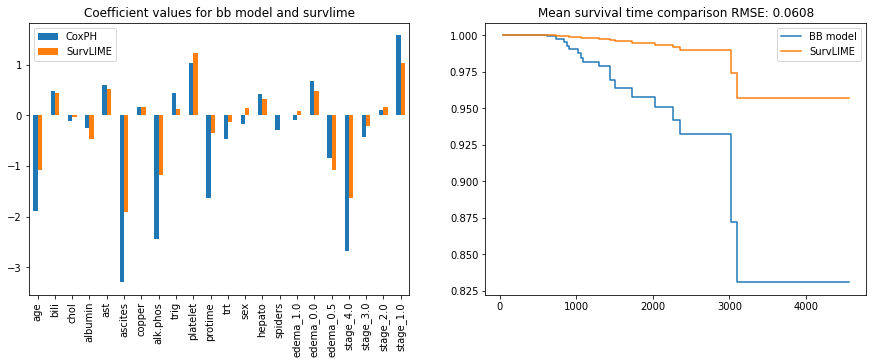

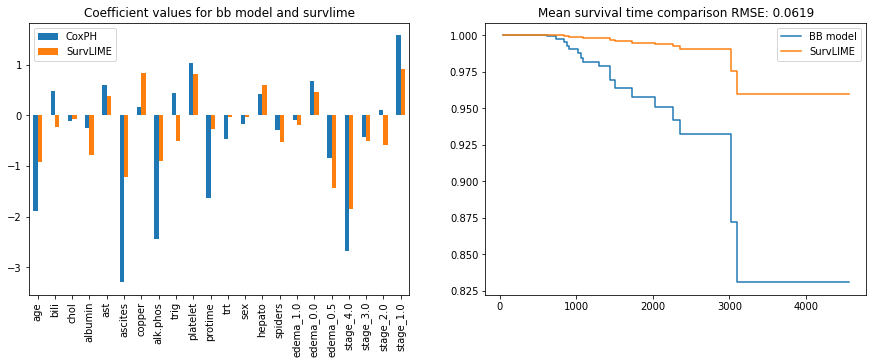

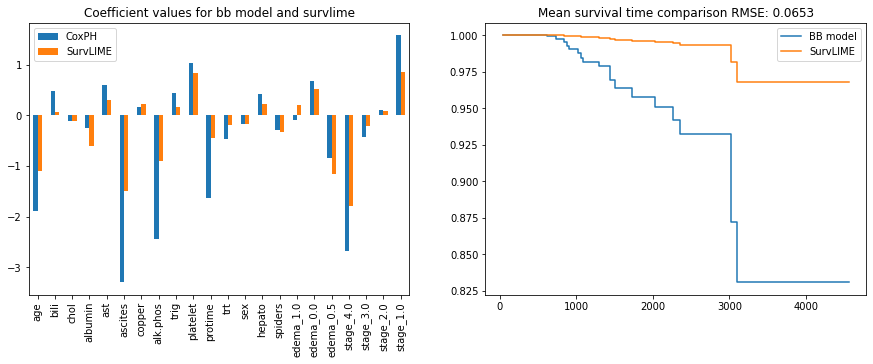

In [30]:
compare_survival_times(model, compt_weights.iloc[closest], train[0], train[1], test[0])
compare_survival_times(model, compt_weights.iloc[furthest], train[0], train[1], test[0])
compare_survival_times(model, compt_weights.mean(), train[0], train[1], test[0])